In [1]:
import numpy as np
from tqdm import tqdm
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.metrics import mean_absolute_error as mae

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('invitro_train.csv')
df['Дата взятия'] = pd.to_datetime(df['Дата взятия'])
df['date'] = df['Дата взятия'].apply(lambda x: pd.to_datetime(x.date()))

REGIONS = sorted(df['Регион'].unique())
TEST_NAMES = sorted(df['Имя теста'].unique())
MIN_DATE = df.date.min()
MAX_DATE = df.date.max()
MAX_TRAIN_DATE = MAX_DATE - datetime.timedelta(days=19)

# COUNT_NAMES = [f'{t} count' for t in TEST_NAMES]
# POS_PERC_NAMES = [f'{t} pos perc' for t in TEST_NAMES]

In [3]:
df.head()

,Имя теста,Код теста,Значение,Регион,Дата взятия,date
0,Borrelia burgdorferi s.l (кач) ДНК,27Д,ОБНАРУЖ.,Челябинская обл,2019-05-25 06:02:00,2019-05-25
1,Borrelia burgdorferi s.l (кач) ДНК,27Д,ОБНАРУЖ.,Челябинская обл,2019-05-27 09:04:00,2019-05-27
2,Вирус клещевого энцефалита(кач) РНК,35Д,НЕ ОБНАР,Челябинская обл,2019-05-27 09:04:00,2019-05-27
3,Borrelia burgdorferi s.l (кач) ДНК,27Д,ОБНАРУЖ.,Челябинская обл,2019-05-27 09:14:00,2019-05-27
4,Вирус клещевого энцефалита(кач) РНК,35Д,НЕ ОБНАР,Челябинская обл,2019-05-27 09:14:00,2019-05-27


In [4]:
def get_pos_perc(values):
    pos = np.sum(np.isin(values, ['ОБНАРУЖ.', 'ОБНАРУЖ', 'Detected']))
    known = np.sum(np.isin(values, ['ОБНАРУЖ.', 'НЕ ОБНАР', 'ОБНАРУЖ', 'Is not detected', 'Detected']))
    return pos / known * 100

In [5]:
dates = pd.date_range(MIN_DATE, MAX_DATE, freq='1d')

data = pd.DataFrame(index=pd.MultiIndex.from_product([REGIONS, TEST_NAMES, dates], names=['Регион', 'Имя теста', 'date']))
data['count'] = 0.
data['pos_perc'] = float('nan')
data['count'].update(df.groupby(['Регион', 'Имя теста', 'date']).size())
data.pos_perc.update(df.groupby(['Регион', 'Имя теста', 'date'])['Значение'].apply(lambda x: get_pos_perc(x.values)))
data = data.reset_index()

<ipython-input-4-6865474db775>:4: RuntimeWarning: invalid value encountered in long_scalars
  return pos / known * 100


In [6]:
data.head()

,Регион,Имя теста,date,count,pos_perc
0,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-13,0.0,NaN
1,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-14,0.0,NaN
2,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-15,0.0,NaN
3,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-16,0.0,NaN
4,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-17,0.0,NaN


# Misha's features

In [7]:
data['year'] = data['date'].apply(lambda x: x.year)
data['month'] = data['date'].apply(lambda x: x.month)
data['day'] = data['date'].apply(lambda x: x.day)

In [8]:
history = data[['Регион', 'Имя теста', 'date', 'count', 'pos_perc']].copy()
for i in range(1, 9):
    history['date'] = history['date'] + datetime.timedelta(days=1)
    data = data.merge(history, how='left', on=['Регион', 'Имя теста', 'date'],
                      suffixes=['', f'_{i}_days_ago'])

In [9]:
data

,Регион,Имя теста,date,count,pos_perc,year,month,day,count_1_days_ago,pos_perc_1_days_ago,...,count_4_days_ago,pos_perc_4_days_ago,count_5_days_ago,pos_perc_5_days_ago,count_6_days_ago,pos_perc_6_days_ago,count_7_days_ago,pos_perc_7_days_ago,count_8_days_ago,pos_perc_8_days_ago
0,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-13,0.0,NaN,2019,2,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-14,0.0,NaN,2019,2,14,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-15,0.0,NaN,2019,2,15,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-16,0.0,NaN,2019,2,16,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-17,0.0,NaN,2019,2,17,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283740,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-04,1.0,0.0,2021,6,4,1.0,0.0,...,3.0,0.0,0.0,NaN,1.0,0.0,1.0,0.0,4.0,0.0
283741,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-05,0.0,NaN,2021,6,5,1.0,0.0,...,0.0,NaN,3.0,0.0,0.0,NaN,1.0,0.0,1.0,0.0
283742,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-06,0.0,NaN,2021,6,6,0.0,NaN,...,1.0,0.0,0.0,NaN,3.0,0.0,0.0,NaN,1.0,0.0
283743,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-06-07,1.0,0.0,2021,6,7,0.0,NaN,...,1.0,0.0,1.0,0.0,0.0,NaN,3.0,0.0,0.0,NaN


In [10]:
data = data.merge(data.groupby('month')['count'].mean(), on='month', suffixes=['', '_mean_by_month'])
data = data.merge(data.groupby('Регион')['count'].mean(), on='Регион', suffixes=['', '_mean_by_region'])
data = data.merge(data.groupby('Имя теста')['count'].mean(), on='Имя теста', suffixes=['', '_mean_by_test_name'])

data = data.merge(data.groupby(['month', 'Имя теста'])['count'].mean().reset_index(),
                  on=['month', 'Имя теста'], suffixes=['', '_mean_by_month_and_test_name'])
data = data.merge(data.groupby(['month', 'Регион'])['count'].mean().reset_index(),
                  on=['month', 'Регион'], suffixes=['', '_mean_by_month_and_region'])
data = data.merge(data.groupby(['Имя теста', 'Регион'])['count'].mean().reset_index(),
                  on=['Имя теста', 'Регион'], suffixes=['', '_mean_by_test_name_and_region'])

data = data.merge(data.groupby(['month', 'Имя теста', 'Регион'])['count'].mean().reset_index(),
                  on=['month', 'Имя теста', 'Регион'], suffixes=['', '_mean_by_month_test_name_and_region'])

In [11]:
data

,Регион,Имя теста,date,count,pos_perc,year,month,day,count_1_days_ago,pos_perc_1_days_ago,...,pos_perc_7_days_ago,count_8_days_ago,pos_perc_8_days_ago,count_mean_by_month,count_mean_by_region,count_mean_by_test_name,count_mean_by_month_and_test_name,count_mean_by_month_and_region,count_mean_by_test_name_and_region,count_mean_by_month_test_name_and_region
0,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-13,0.0,NaN,2019,2,13,NaN,NaN,...,NaN,NaN,NaN,0.001227,0.005195,0.782868,0.000204,0.0,0.000000,0.0
1,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-14,0.0,NaN,2019,2,14,0.0,NaN,...,NaN,NaN,NaN,0.001227,0.005195,0.782868,0.000204,0.0,0.000000,0.0
2,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-15,0.0,NaN,2019,2,15,0.0,NaN,...,NaN,NaN,NaN,0.001227,0.005195,0.782868,0.000204,0.0,0.000000,0.0
3,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-16,0.0,NaN,2019,2,16,0.0,NaN,...,NaN,NaN,NaN,0.001227,0.005195,0.782868,0.000204,0.0,0.000000,0.0
4,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-17,0.0,NaN,2019,2,17,0.0,NaN,...,NaN,NaN,NaN,0.001227,0.005195,0.782868,0.000204,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283740,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-01-27,0.0,NaN,2021,1,27,0.0,NaN,...,NaN,0.0,NaN,0.000578,0.076505,1.756771,0.001204,0.0,0.191263,0.0
283741,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-01-28,0.0,NaN,2021,1,28,0.0,NaN,...,NaN,0.0,NaN,0.000578,0.076505,1.756771,0.001204,0.0,0.191263,0.0
283742,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-01-29,0.0,NaN,2021,1,29,0.0,NaN,...,NaN,0.0,NaN,0.000578,0.076505,1.756771,0.001204,0.0,0.191263,0.0
283743,Ярославская обл,Вирус клещевого энцефалита(кач) РНК,2021-01-30,0.0,NaN,2021,1,30,0.0,NaN,...,NaN,0.0,NaN,0.000578,0.076505,1.756771,0.001204,0.0,0.191263,0.0


# Masha's features

In [12]:
soc_econom = pd.read_csv('data_12_00.csv')
soc_econom = soc_econom.drop(['Код теста', 'Значение', 'Дата взятия', 'Имя теста'], axis=1).drop_duplicates()
soc_econom['Income'] = soc_econom['Income'].apply(lambda x: float(''.join(x.split(' '))))
data = data.merge(soc_econom, how='left', on='Регион')

In [13]:
num_offices = pd.read_csv('data_off_invitro.csv').rename({'number': 'num_offices'}, axis=1)
data = data.merge(num_offices, how='left', on='Регион dadata')

In [14]:
data.head()

,Регион,Имя теста,date,count,pos_perc,year,month,day,count_1_days_ago,pos_perc_1_days_ago,...,специалист,магистр,неполно высшее,среднее,среднее (полное),основное,нет образования,начальное общее,начальное профессиональное,num_offices
0,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-13,0.0,NaN,2019,2,13,NaN,NaN,...,196.0,3.0,41.0,288.0,211.0,127.0,8.0,61.0,51.0,2.0
1,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-14,0.0,NaN,2019,2,14,0.0,NaN,...,196.0,3.0,41.0,288.0,211.0,127.0,8.0,61.0,51.0,2.0
2,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-15,0.0,NaN,2019,2,15,0.0,NaN,...,196.0,3.0,41.0,288.0,211.0,127.0,8.0,61.0,51.0,2.0
3,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-16,0.0,NaN,2019,2,16,0.0,NaN,...,196.0,3.0,41.0,288.0,211.0,127.0,8.0,61.0,51.0,2.0
4,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2019-02-17,0.0,NaN,2019,2,17,0.0,NaN,...,196.0,3.0,41.0,288.0,211.0,127.0,8.0,61.0,51.0,2.0


# Ilya's features

In [15]:
def holidays_and_weekends(
    date,
    holidays_range: list,
) -> float:
    
    #check if weekend
    if date.weekday() >= 5:
        return 1.
    
    #check if holiday:
    for holiday_range in holidays_range:
        lower = pd.to_datetime(holiday_range['lower'])
        upper = pd.to_datetime(holiday_range['upper'])
        if lower <= date <= upper:
            return 1.
    
    return 0.

In [16]:
with open('map_date_to_holiday.json', 'r') as fp:
    holidays_range = json.load(fp)

In [17]:
dates = pd.date_range(MIN_DATE, MAX_DATE, freq='1d')
holidays = pd.DataFrame(
    data=zip(dates, [holidays_and_weekends(day, holidays_range) for day in dates]),
    columns=['date', 'holiday']
)

history = holidays.copy()
for i in range(1, 8):
    history['date'] = history['date'] + datetime.timedelta(days=1)
    holidays = holidays.merge(history, how='left', on='date', suffixes=['', f'_{i}_days_ago'])

In [18]:
data = data.merge(holidays, on='date')

In [20]:
with open('map_name_to_population.json', 'r') as fp:
    map_name_to_population = json.load(fp)

In [26]:
population = pd.DataFrame.from_dict(map_name_to_population,
                                    orient='index',
                                    columns=['city_population', 'vilage_population'])
population.index.name = 'Регион'
population = population.reset_index()

In [27]:
data = data.merge(population, on='Регион')

# Ivan's features

In [31]:
temps = pd.read_csv('temps_train.csv').drop('Unnamed: 0', axis=1)

In [32]:
temps['date'] = temps.apply(
    lambda row: pd.to_datetime(datetime.date(year=row['y'], month=row['m'], day=row['d'])), axis=1)
temps = temps.rename({'region': 'Регион'}, axis=1)
temps = temps.drop(['y', 'm', 'd'], axis=1)
temps

,Регион,t_min,t_max,y_coor,x_coor,date
0,Алтай Респ,-29.350000,-14.775000,52.950000,102.675000,2019-02-13
1,Алтайский край,-26.722222,-12.488889,53.633333,92.711111,2019-02-13
2,Астраханская обл,-7.950000,2.100000,47.250000,47.300000,2019-02-13
3,Башкортостан Респ,-18.912500,-3.537500,53.412500,60.175000,2019-02-13
4,Белгородская обл,-2.200000,2.033333,50.823333,38.716667,2019-02-13
...,...,...,...,...,...,...
8695,Челябинская обл,5.480000,18.940000,56.060000,78.980000,2020-06-27
8696,Чеченская Респ,12.600000,27.300000,43.300000,45.900000,2020-06-27
8697,Чувашская Респ,9.266667,20.333333,59.326667,63.443333,2020-06-27
8698,Ямало-Ненецкий АО,11.400000,16.937500,65.975000,75.125000,2020-06-27


In [33]:
history = temps[['date', 'Регион', 't_min', 't_max']]
for i in range(1, 8):
    history['date'] = history['date'] + datetime.timedelta(days=1)
    temps = temps.merge(history, how='left', on=['date', 'Регион'], suffixes=['', f'_{i}_days_ago'])

<ipython-input-33-feba2f0170a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['date'] = history['date'] + datetime.timedelta(days=1)


In [34]:
data = data.merge(temps, how='left', on=['Регион', 'date'])

In [35]:
humidity = pd.read_csv('humidity_train.csv').drop('Unnamed: 0', axis=1)
humidity = humidity.rename({'y': 'year', 'm': 'month', 'region': 'Регион'}, axis=1)
humidity

,year,month,Регион,humidity
0,2019,2,Алтай Респ,64.250000
1,2019,2,Алтайский край,70.222222
2,2019,2,Астраханская обл,82.500000
3,2019,2,Башкортостан Респ,77.125000
4,2019,2,Белгородская обл,83.333333
...,...,...,...,...
633,2019,12,Челябинская обл,75.500000
634,2019,12,Чеченская Респ,88.000000
635,2019,12,Чувашская Респ,82.333333
636,2019,12,Ямало-Ненецкий АО,81.166667


In [36]:
data = data.merge(humidity, how='left', on=['year', 'month', 'Регион'])

In [37]:
_train = data['date'] <= datetime.datetime.combine(MAX_TRAIN_DATE, datetime.time())
data_train = data[_train]
data_test = data[~_train]

In [38]:
data_train = data_train[~data_train['month'].isin([12, 1, 2])]

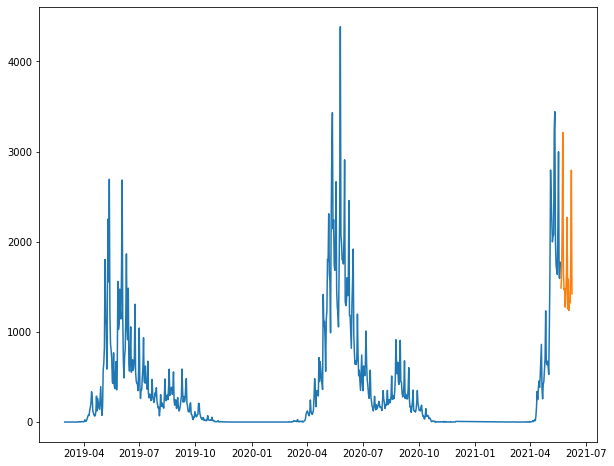

In [39]:
plt.figure(figsize=(10, 8))
plt.plot(data_train.groupby('date')['count'].sum())
plt.plot(data_test.groupby('date')['count'].sum())

In [40]:
data.columns

Index(['Регион', 'Имя теста', 'date', 'count', 'pos_perc', 'year', 'month',
       'day', 'count_1_days_ago', 'pos_perc_1_days_ago', 'count_2_days_ago',
       'pos_perc_2_days_ago', 'count_3_days_ago', 'pos_perc_3_days_ago',
       'count_4_days_ago', 'pos_perc_4_days_ago', 'count_5_days_ago',
       'pos_perc_5_days_ago', 'count_6_days_ago', 'pos_perc_6_days_ago',
       'count_7_days_ago', 'pos_perc_7_days_ago', 'count_8_days_ago',
       'pos_perc_8_days_ago', 'count_mean_by_month', 'count_mean_by_region',
       'count_mean_by_test_name', 'count_mean_by_month_and_test_name',
       'count_mean_by_month_and_region', 'count_mean_by_test_name_and_region',
       'count_mean_by_month_test_name_and_region', 'Регион dadata',
       'avaliable', 'price', 'Income', 'послевузовское', 'высшее', 'бакалавр',
       'специалист', 'магистр', 'неполно высшее', 'среднее',
       'среднее (полное)', 'основное', 'нет образования', 'начальное общее',
       'начальное профессиональное', 'num_offices

In [82]:
feature_names = [
    *[f'count_{i}_days_ago' for i in range(1, 9)],
    *[f'pos_perc_{i}_days_ago' for i in range(1, 9)],
    'count_mean_by_month', 
    'count_mean_by_region', 
    'count_mean_by_test_name',
    'count_mean_by_month_and_test_name', 
    'count_mean_by_month_and_region', 
    'count_mean_by_test_name_and_region',
    'count_mean_by_month_test_name_and_region',
    'avaliable',
    'price',
    'Income',
    *['послевузовское', 'высшее', 'бакалавр', 'специалист', 'магистр',
      'неполно высшее', 'среднее', 'среднее (полное)', 'основное',
      'нет образования', 'начальное общее', 'начальное профессиональное'],
    'num_offices',
    'holiday', *[f'holiday_{i}_days_ago' for i in range(1, 8)],
    't_min', *[f't_min_{i}_days_ago' for i in range(1, 8)],
    't_max', *[f't_max_{i}_days_ago' for i in range(1, 8)],
    'x_coor', 'y_coor',
    'humidity',
    'city_population',
    'vilage_population',
]

<AxesSubplot:>

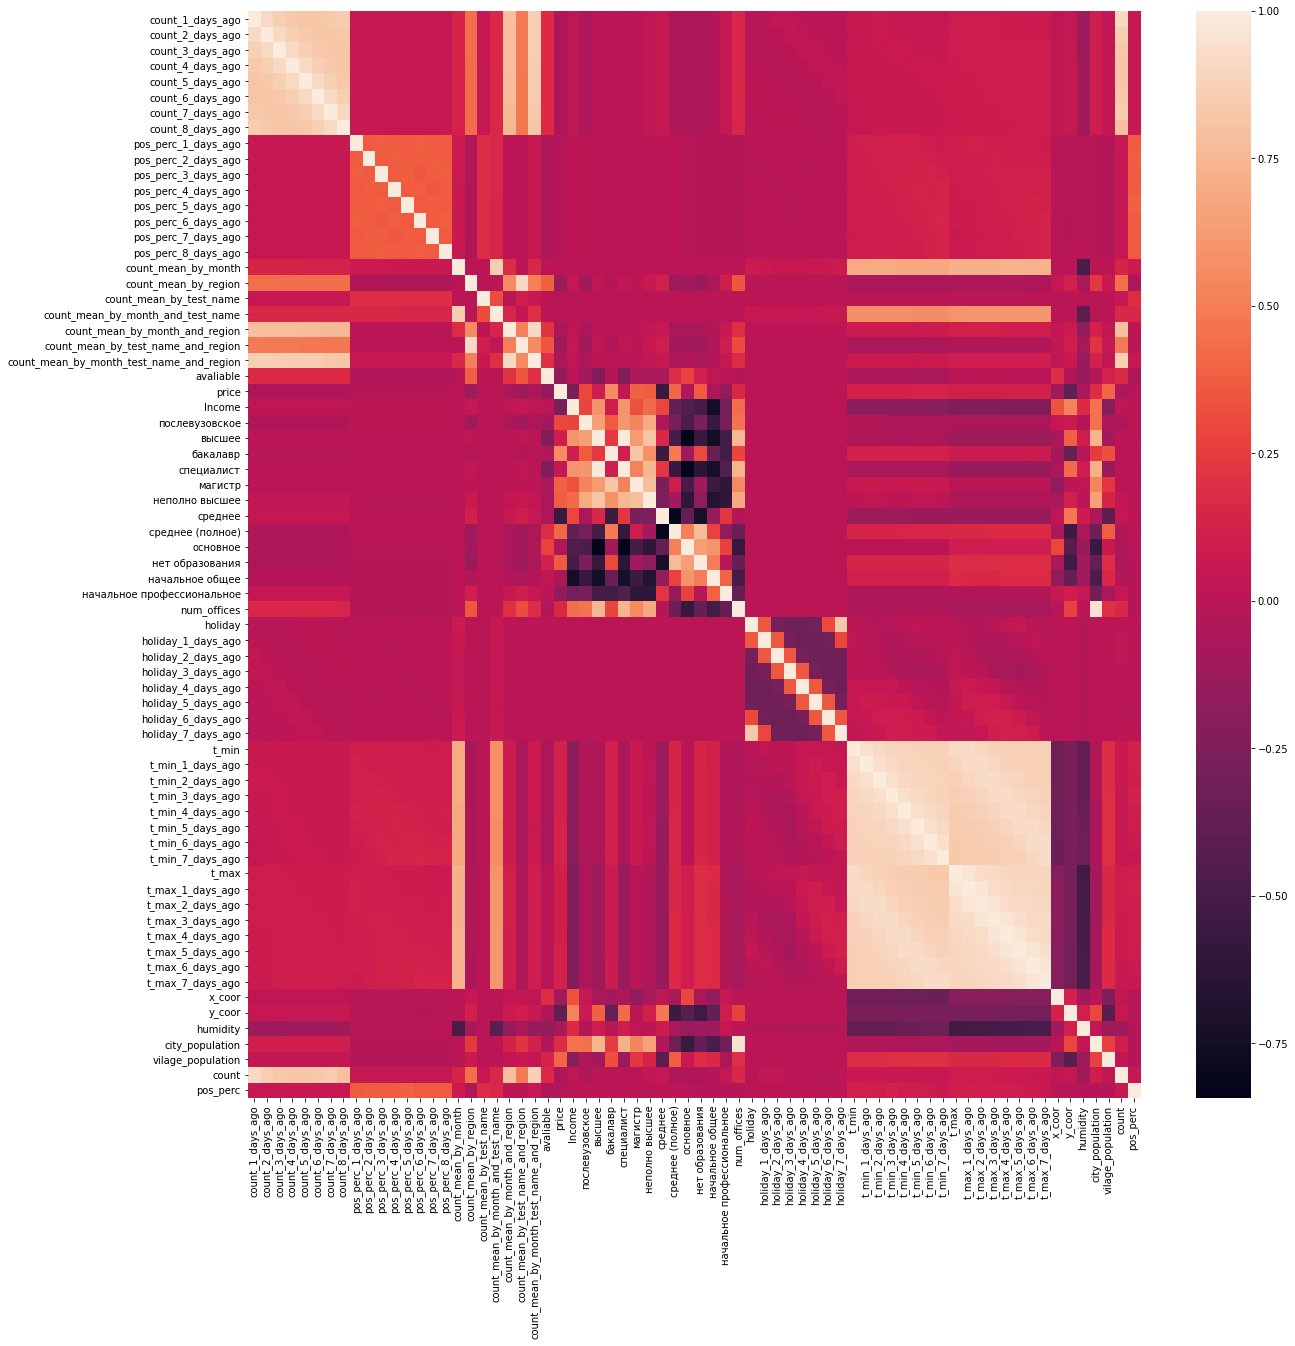

In [88]:
plt.figure(figsize=(20, 20))
sns.heatmap(data[[*feature_names, 'count', 'pos_perc']].corr())

In [69]:
xgb = XGBClassifier(n_estimators=100, max_depth=10, tree_method='gpu_hist')

In [76]:
xgb.fit(data_train[feature_names], data_train['count'])

/nmnt/media/home/migonch/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [77]:
data_test['count_pred'] = xgb.predict(data_test[feature_names])

<ipython-input-77-62c53f341c0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['count_pred'] = xgb.predict(data_test[feature_names])


In [78]:
non_zero = data_test['count'] != 0
mae(data_test['count'][non_zero], data_test['count_pred'][non_zero])

6.764571428571428

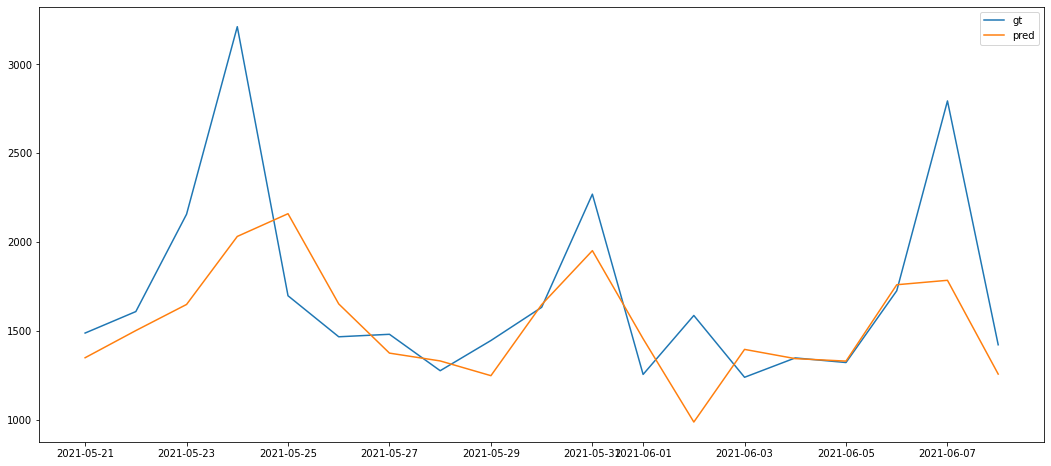

In [79]:
plt.figure(figsize=(18, 8))
plt.plot(data_test.groupby('date')['count'].sum(), label='gt')
plt.plot(data_test.groupby('date')['count_pred'].sum(), label='pred')
plt.legend()

<BarContainer object of 20 artists>

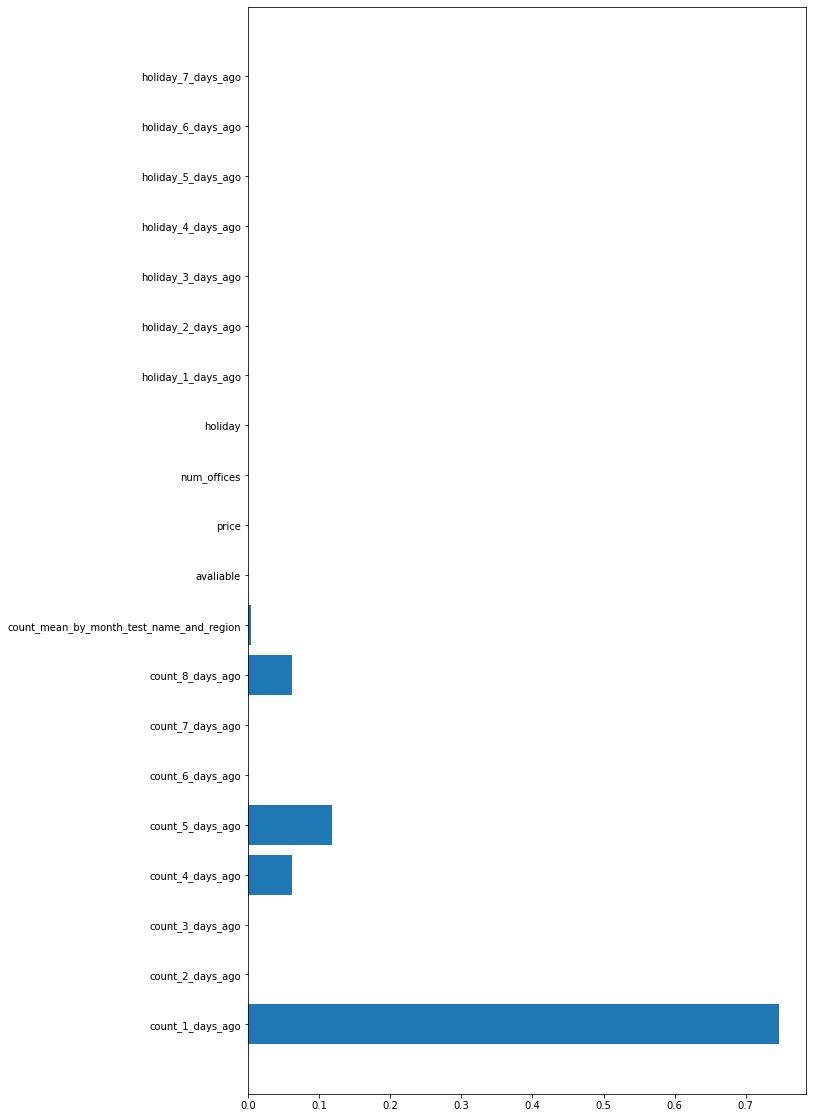

In [80]:
plt.figure(figsize=(10, 20))
plt.barh(y=feature_names, 
         width=xgb.feature_importances_)

# Submission

In [279]:
DATES = pd.date_range('2021.06.01', '2021.06.27', freq='1d')

In [280]:
test_data = pd.DataFrame(index=pd.MultiIndex.from_product([REGIONS, TEST_NAMES, DATES], names=['Регион', 'Имя теста', 'date']))
test_data['count'] = float('nan')
test_data['pos_perc'] = float('nan')
test_data['count'].update(df.groupby(['Регион', 'Имя теста', 'date']).size())
test_data.pos_perc.update(df.groupby(['Регион', 'Имя теста', 'date'])['Значение'].apply(lambda x: get_pos_perc(x.values)))
test_data = test_data.reset_index()
test_data.loc[test_data['count'].isna() & (test_data['date'] < pd.to_datetime('2021.06.09')), 'count'] = 0

<ipython-input-181-6865474db775>:4: RuntimeWarning: invalid value encountered in long_scalars
  return pos / known * 100


In [281]:
test_data['year'] = test_data['date'].apply(lambda x: x.year)
test_data['month'] = test_data['date'].apply(lambda x: x.month)
test_data['day'] = test_data['date'].apply(lambda x: x.day)

In [282]:
test_data = test_data.merge(data.groupby(['month', 'Имя теста', 'Регион'])['count'].mean().reset_index(),
                            how='left',
                            on=['month', 'Имя теста', 'Регион'],
                            suffixes=['', '_mean_by_month_test_name_and_region'])

In [283]:
soc_econom = pd.read_csv('data_12_00.csv')
soc_econom = soc_econom.drop(['Код теста', 'Значение', 'Дата взятия', 'Имя теста'], axis=1).drop_duplicates()
soc_econom['Income'] = soc_econom['Income'].apply(lambda x: float(''.join(x.split(' '))))
test_data = test_data.merge(soc_econom, how='left', on='Регион')

In [284]:
holidays = pd.DataFrame(
    data=zip(DATES, [holidays_and_weekends(day, holidays_range) for day in DATES]),
    columns=['date', 'holiday']
)

history = holidays.copy()
for i in range(1, 8):
    history['date'] = history['date'] + datetime.timedelta(days=1)
    holidays = holidays.merge(history, how='left', on='date', suffixes=['', f'_{i}_days_ago'])

In [285]:
test_data = test_data.merge(holidays, on='date')

In [286]:
history = test_data[['Регион', 'Имя теста', 'date', 'count', 'pos_perc']].copy()
for i in range(1, 9):
    history['date'] = history['date'] + datetime.timedelta(days=1)
    test_data = test_data.merge(history, how='left', on=['Регион', 'Имя теста', 'date'],
                                suffixes=['', f'_{i}_days_ago'])

In [287]:
num_offices = pd.read_csv('data_off_invitro.csv').rename({'number': 'num_offices'}, axis=1)
test_data = test_data.merge(num_offices, how='left', on='Регион dadata')

In [288]:
test_data['count_pred'] = float('nan')
test_data['pos_perc_pred'] = float('nan')

In [289]:
for date in tqdm(pd.date_range('2021.06.09', '2021.06.27', freq='1d')):
    date_test_data = test_data[test_data.date == date]
    date_count_pred = xgb.predict(date_test_data[feature_names])
    test_data['count_pred'][test_data.date == date] = date_count_pred
    for i in range(1, 9):
        if date + datetime.timedelta(days=i) > pd.to_datetime('2021.06.27'):
            continue
        assert test_data.loc[test_data.date == date + datetime.timedelta(days=i), f'count_{i}_days_ago'].isna().all()
        test_data.loc[test_data.date == date + datetime.timedelta(days=i), f'count_{i}_days_ago'] = date_count_pred

  0%|          | 0/19 [00:00<?, ?it/s]<ipython-input-289-a7bdd0eeca12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['count_pred'][test_data.date == date] = date_count_pred
100%|██████████| 19/19 [00:00<00:00, 31.88it/s]


In [339]:
test_data.loc[test_data.date >= pd.to_datetime('2021.06.09'), 'pos_perc_pred'] = xgb2.predict(
    test_data[feature_names][test_data.date >= pd.to_datetime('2021.06.09')])

In [345]:
test_data

,Регион,Имя теста,date,count,pos_perc,year,month,day,count_mean_by_month_test_name_and_region,Регион dadata,...,count_6_days_ago,pos_perc_6_days_ago,count_7_days_ago,pos_perc_7_days_ago,count_8_days_ago,pos_perc_8_days_ago,num_offices,count_pred,pos_perc_pred,pos_proc_pred
0,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2021-06-01,0.0,NaN,2021,6,1,0.000000,Адыгея,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-01,1.0,100.0,2021,6,1,0.029412,Адыгея,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
2,Адыгея Респ,Borrelia miyamotoi (кач) ДНК,2021-06-01,0.0,NaN,2021,6,1,0.000000,Адыгея,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
3,Адыгея Респ,Ehrlichia muris/chaffeеnsis(кач) ДНК,2021-06-01,0.0,NaN,2021,6,1,0.000000,Адыгея,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
4,Адыгея Респ,Вирус клещевого энцефалита(кач) РНК,2021-06-01,1.0,0.0,2021,6,1,0.029412,Адыгея,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9040,Ярославская обл,Anaplasma Phagocytophillum(кач) ДНК,2021-06-27,NaN,NaN,2021,6,27,0.000000,Ярославская,...,0.0,NaN,0.0,NaN,0.0,NaN,8.0,0.0,0.0,NaN
9041,Ярославская обл,Borrelia burgdorferi s.l (кач) ДНК,2021-06-27,NaN,NaN,2021,6,27,0.441176,Ярославская,...,0.0,NaN,1.0,NaN,0.0,NaN,8.0,0.0,0.0,0.0
9042,Ярославская обл,Borrelia miyamotoi (кач) ДНК,2021-06-27,NaN,NaN,2021,6,27,0.000000,Ярославская,...,0.0,NaN,0.0,NaN,0.0,NaN,8.0,0.0,0.0,NaN
9043,Ярославская обл,Ehrlichia muris/chaffeеnsis(кач) ДНК,2021-06-27,NaN,NaN,2021,6,27,0.000000,Ярославская,...,0.0,NaN,0.0,NaN,0.0,NaN,8.0,0.0,0.0,NaN


In [346]:
test_data

,Регион,Имя теста,date,count,pos_perc,year,month,day,count_mean_by_month_test_name_and_region,Регион dadata,...,count_6_days_ago,pos_perc_6_days_ago,count_7_days_ago,pos_perc_7_days_ago,count_8_days_ago,pos_perc_8_days_ago,num_offices,count_pred,pos_perc_pred,pos_proc_pred
0,Адыгея Респ,Anaplasma Phagocytophillum(кач) ДНК,2021-06-01,0.0,NaN,2021,6,1,0.000000,Адыгея,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
1,Адыгея Респ,Borrelia burgdorferi s.l (кач) ДНК,2021-06-01,1.0,100.0,2021,6,1,0.029412,Адыгея,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
2,Адыгея Респ,Borrelia miyamotoi (кач) ДНК,2021-06-01,0.0,NaN,2021,6,1,0.000000,Адыгея,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
3,Адыгея Респ,Ehrlichia muris/chaffeеnsis(кач) ДНК,2021-06-01,0.0,NaN,2021,6,1,0.000000,Адыгея,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
4,Адыгея Респ,Вирус клещевого энцефалита(кач) РНК,2021-06-01,1.0,0.0,2021,6,1,0.029412,Адыгея,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9040,Ярославская обл,Anaplasma Phagocytophillum(кач) ДНК,2021-06-27,NaN,NaN,2021,6,27,0.000000,Ярославская,...,0.0,NaN,0.0,NaN,0.0,NaN,8.0,0.0,0.0,NaN
9041,Ярославская обл,Borrelia burgdorferi s.l (кач) ДНК,2021-06-27,NaN,NaN,2021,6,27,0.441176,Ярославская,...,0.0,NaN,1.0,NaN,0.0,NaN,8.0,0.0,0.0,0.0
9042,Ярославская обл,Borrelia miyamotoi (кач) ДНК,2021-06-27,NaN,NaN,2021,6,27,0.000000,Ярославская,...,0.0,NaN,0.0,NaN,0.0,NaN,8.0,0.0,0.0,NaN
9043,Ярославская обл,Ehrlichia muris/chaffeеnsis(кач) ДНК,2021-06-27,NaN,NaN,2021,6,27,0.000000,Ярославская,...,0.0,NaN,0.0,NaN,0.0,NaN,8.0,0.0,0.0,NaN


In [349]:
DATES = pd.date_range('2021.06.09', '2021.06.27', freq='1d')

submission = pd.DataFrame()
for region in tqdm(REGIONS):
    region_submission = pd.DataFrame(index=DATES)
    region_submission['region'] = region
    for test_name in TEST_NAMES:
        for date in DATES:
            _data = test_data[(test_data['Регион'] == region) & (test_data['Имя теста'] == test_name) & (test_data['date'] == date)]
            assert len(_data) == 1
            region_submission.loc[date, f'{test_name} count'] = _data.iloc[0]['count_pred']
            region_submission.loc[date, f'{test_name} pos perc'] = _data.iloc[0]['pos_perc_pred']
        
    submission = submission.append(region_submission)

100%|██████████| 67/67 [00:17<00:00,  3.88it/s]


In [350]:
def validate_submission(submission):
    if isinstance(submission, str):
        submission = pd.read_csv(submission, index_col=0)
        
    assert submission.shape == (1273, 11), 'invalid shape'
    true_cols = [
       'region',
       'Anaplasma Phagocytophillum(кач) ДНК count',
       'Anaplasma Phagocytophillum(кач) ДНК pos perc',
       'Borrelia burgdorferi s.l (кач) ДНК count',
       'Borrelia burgdorferi s.l (кач) ДНК pos perc',
       'Borrelia miyamotoi (кач) ДНК count',
       'Borrelia miyamotoi (кач) ДНК pos perc',
       'Ehrlichia muris/chaffeеnsis(кач) ДНК count',
       'Ehrlichia muris/chaffeеnsis(кач) ДНК pos perc',
       'Вирус клещевого энцефалита(кач) РНК count',
       'Вирус клещевого энцефалита(кач) РНК pos perc']
    
    assert np.array_equal(submission.columns, true_cols), 'invalid cols'
    assert submission.isnull().sum().sum() == 0, 'null values'
    assert (submission.iloc[:, 1:] < 0).sum().sum() == 0, 'negative values'
    print('validation success')

In [351]:
validate_submission(submission)

validation success


In [358]:
submission_path = 'submission.csv'
submission.to_csv(submission_path)

In [362]:
def submit_file(submission_path):
    files = {'file': (submission_path, open(submission_path,'rb'), 'text/x-spam')}
    TOKEN = "3300a168-1d6d-4404-b28e-fafe63dda62d"
    values = {'token': TOKEN}
    return requests.post('http://130.193.54.199:23030/', files=files, data=values)

res = submit_file(submission_path)
res.content

b'{\n  "daily_submits": 4, \n  "date": "2021-06-27 14:14:00", \n  "score": "to be announced", \n  "task_name": "invitro", \n  "team_name": "U-know"\n}\n'